### (1) Introduction

Diabetes is a growing public health issue worldwide, and early detection is crucial for effective management and prevention of complications. This project uses data provided by the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK). The dataset contains diagnostic measurements of Pima Indian females aged 21 and older. Our primary research question is:

- **Which diagnostic measurements are the strongest predictors of whether a patient has diabetes, and how do these factors interact to influence the likelihood of diagnosis?**

To answer this, we apply **logistic regression** as the response variable is binary (1 = diabetes, 0 = no diabetes). We also explore **Lasso regression** and evaluate model performance using **AUC** to compare prediction accuracy

### (2) Methods and Results

#### (a) Exploratory Data Analysis (EDA)

In [1]:
# Main developer: Chris, Kunyue, Uday, Yiran

install.packages('cowplot')
install.packages('GGally')
install.packages("ROCR") 
install.packages("leaps")
install.packages("corrplot")
install.packages("glmnet")
# # loading the libararies
library(tidyverse)
library(cowplot)
library(GGally)
library(caret)      # For model training and evaluation
library(ggplot2)    # For visualization
library(pROC)       # For ROC and AUC calculation
library(corrplot)
library(ROCR)
library(glmnet)

library(readr)
library(car)
library(dplyr)
library(ggplot2)
library(broom)
library(leaps)
library(tibble)
library(pROC)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to beco

In [2]:
diabetes_data<-read_csv("data/diabetes.csv")
head(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [3]:
data_cleaned <- diabetes_data %>%
  mutate(across(c(Glucose, BloodPressure, SkinThickness, Insulin, BMI), ~ifelse(. == 0, NA, .))) %>%
  drop_na()

cat("Number of rows after cleaning: ", nrow(data_cleaned), "\n")
summary(data_cleaned)

Number of rows after cleaning:  392 


  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Ou

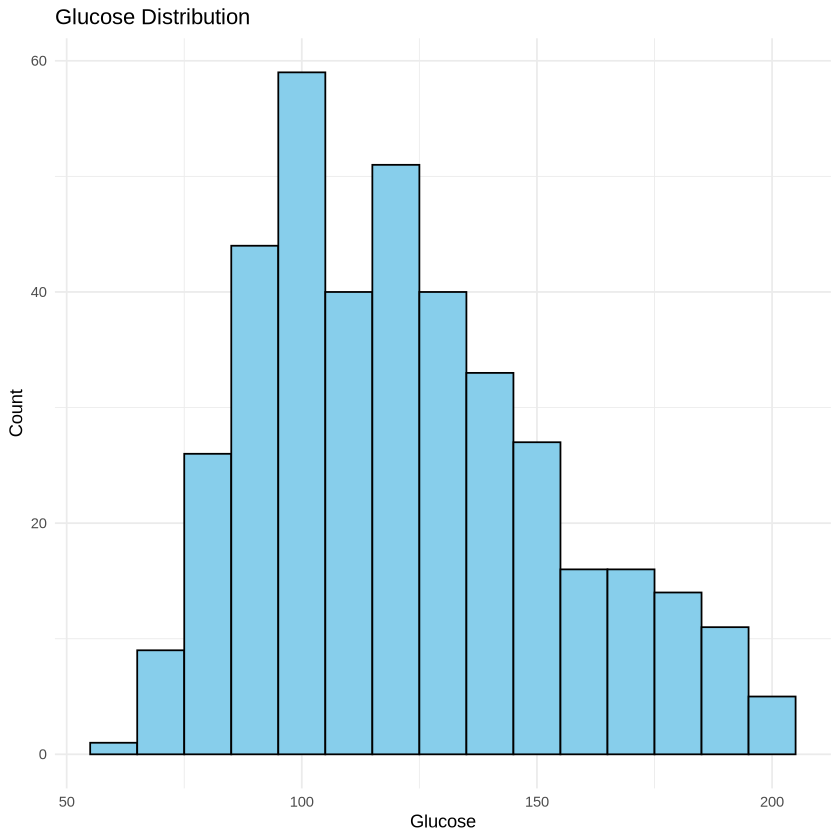

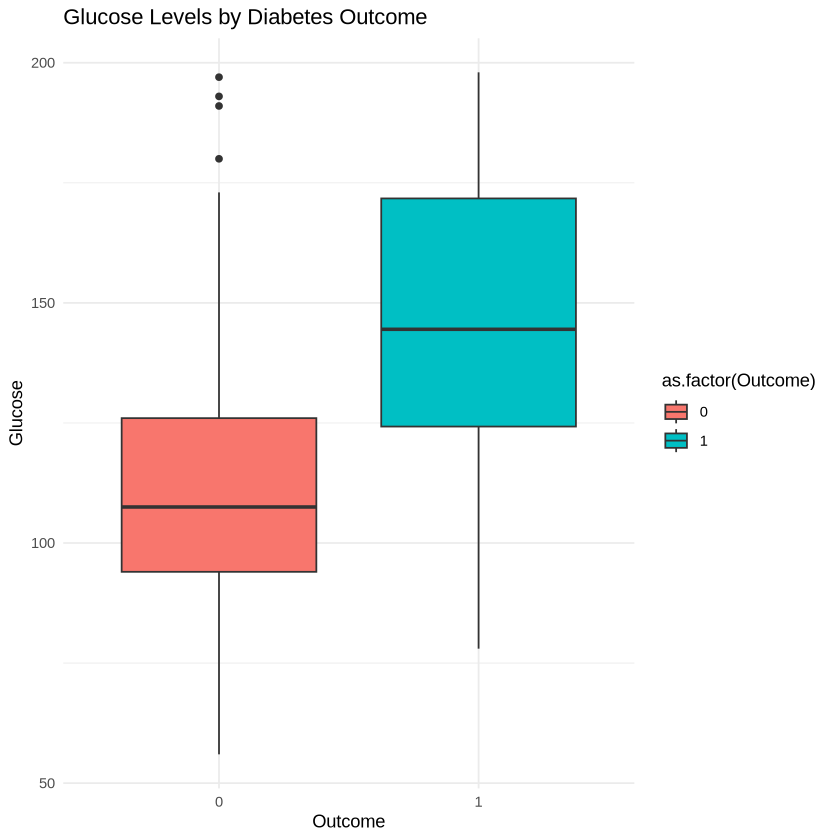

In [4]:
# Distribution of Glucose
ggplot(data_cleaned, aes(x = Glucose)) +
  geom_histogram(binwidth = 10, fill = "skyblue", color = "black") +
  labs(title = "Glucose Distribution", x = "Glucose", y = "Count") +
  theme_minimal()

# Boxplot of Glucose by Outcome
ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Glucose, fill = as.factor(Outcome))) +
  geom_boxplot() +
  labs(title = "Glucose Levels by Diabetes Outcome", x = "Outcome", y = "Glucose") +
  theme_minimal()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000000,0.1982910,0.2133548,0.0932094,0.07898363,-0.02534728,0.007562116,0.67960847
Glucose,0.198291043,1.0000000,0.2100266,0.1988558,0.58122301,0.20951592,0.140180180,0.34364150
BloodPressure,0.213354775,0.2100266,1.0000000,0.2325712,0.09851150,0.30440337,-0.015971104,0.30003895
SkinThickness,0.093209397,0.1988558,0.2325712,1.0000000,0.18219906,0.66435487,0.160498526,0.16776114
Insulin,0.078983625,0.5812230,0.0985115,0.1821991,1.00000000,0.22639652,0.135905781,0.21708199
BMI,-0.025347276,0.2095159,0.3044034,0.6643549,0.22639652,1.00000000,0.158771043,0.06981380
DiabetesPedigreeFunction,0.007562116,0.1401802,-0.0159711,0.1604985,0.13590578,0.15877104,1.000000000,0.08502911
Age,0.679608470,0.3436415,0.3000389,0.1677611,0.21708199,0.06981380,0.085029106,1.00000000


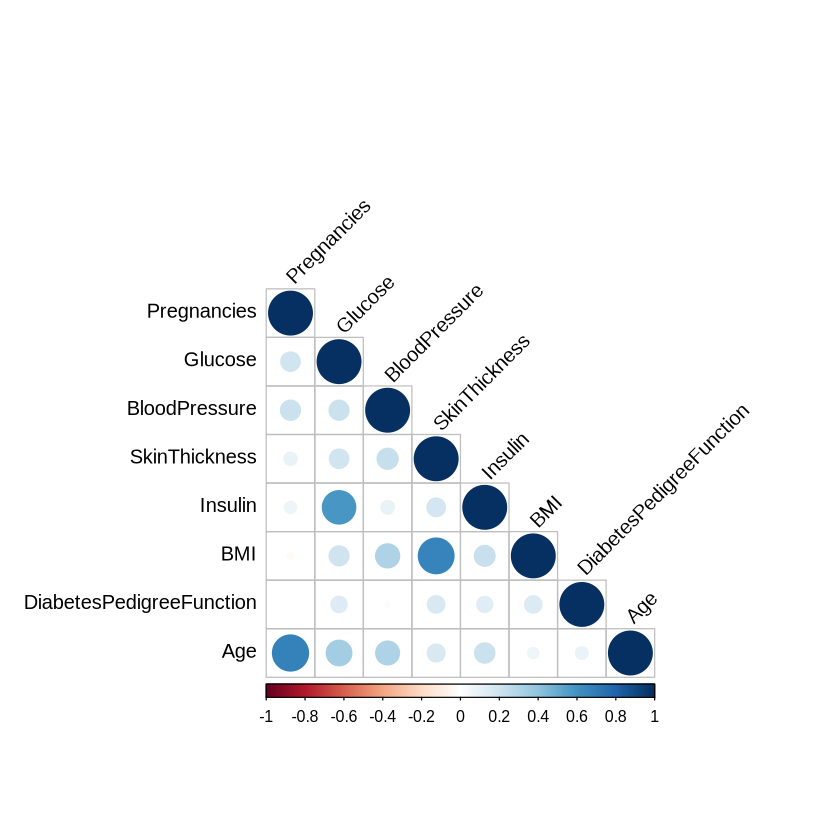

In [5]:
numeric_vars <- data_cleaned %>% select(-Outcome)
cor_matrix <- cor(numeric_vars)
cor_matrix
corrplot(cor_matrix, method = "circle", type = "lower", tl.col = "black", tl.srt = 45)

In [6]:
scaled_data <- data_cleaned %>%
  mutate(across(-Outcome, scale))
head(scaled_data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
-0.71651083,-1.0896533,-0.37317791,-0.5843629,-0.5221747,-0.7095143,-1.0305593,-0.9670632,0
-1.02789913,0.4657189,-2.45382847,0.5567094,0.1005024,1.4249091,5.1085822,0.2093178,1
-0.09373423,-1.4460927,-1.65357826,0.2714413,-0.5726620,-0.2968591,-0.7961084,-0.4769045,1
-0.40512253,2.4099341,-0.05307782,1.5076030,3.2559608,-0.3680065,-1.0566094,2.1699528,1
-0.71651083,2.1507054,-0.85332804,-0.5843629,5.8055711,-0.4249245,-0.3619399,2.7581434,1
0.52904237,1.4054229,0.10697222,-0.9647204,0.1594043,-1.0367925,0.1851123,1.9738893,1


#### (b) Methods: Plan 

Method in English: Need to be added by Yiran

Result from Out Individual Assignment

In [7]:
# Main developer: Yiran Hou

diabetes_selected <- diabetes_data[, c("Glucose", "BMI", "Age", "Outcome")]

#training data/testing data
set.seed(123)
diabetes_train <- 
    diabetes_selected %>% 
    slice_sample(prop = 0.70)

diabetes_test <- 
    diabetes_selected %>% 
    anti_join(diabetes_train, by = c("Glucose", "BMI", "Age", "Outcome"))

additive_selection <- regsubsets(Outcome ~ Glucose + BMI + Age, 
                                 data = diabetes_train, 
                                 nvmax = 3, 
                                 method = "forward")

interactive_selection <- regsubsets(Outcome ~ Glucose * BMI + Glucose * Age + BMI * Age, 
                                    data = diabetes_train, 
                                    nvmax = 6,
                                    method = "forward")

additive_summary <- summary(additive_selection)

interactive_summary <- summary(interactive_selection)

comparison_tibble <- tibble(
  Model = c(rep("Additive", 3), rep("Interactive", 6)),
  n_input_variables = c(1:3, 1:6),
  Adjusted_R2 = c(additive_summary$adjr2, interactive_summary$adjr2),
  BIC = c(additive_summary$bic, interactive_summary$bic),
  Cp = c(additive_summary$cp, interactive_summary$cp)
)


logistic_model <- glm(Outcome ~ Glucose + BMI + Age, data = diabetes_train, family = binomial)
tidy_logistic_model <- tidy(logistic_model, conf.int = TRUE)

tidy_logistic_model <- 
    tidy_logistic_model %>%
        mutate(oddsratio = exp(estimate),
               lowerci = exp(conf.low),
               upperci = exp(conf.high)) %>%
        select(term, oddsratio, lowerci, upperci, p.value)

tidy_logistic_model

term,oddsratio,lowerci,upperci,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00022876,4.592442e-05,0.001007777,1.608471e-26
Glucose,1.03285931,1.024942e+00,1.041386368,1.486893e-15
BMI,1.08467504,1.051583e+00,1.121031855,6.070357e-07
Age,1.03076913,1.012609e+00,1.049490579,8.713864e-04


Setting levels: control = 0, case = 1

Setting direction: controls < cases



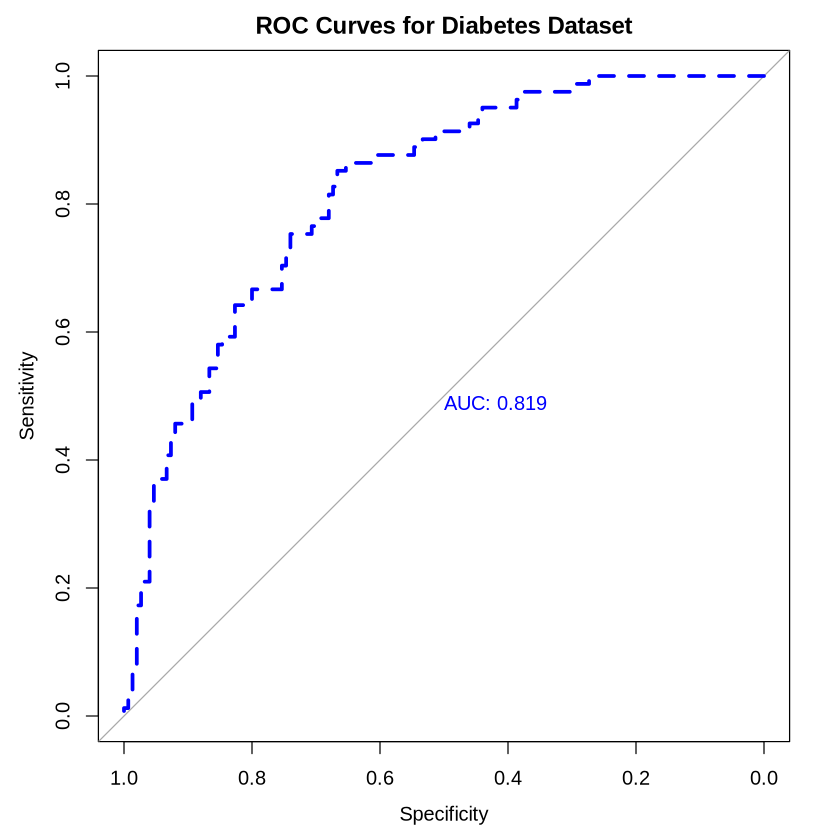

In [8]:
roc_curve <- 
    roc(
        response = diabetes_test$Outcome, 
        predictor = predict(logistic_model, newdata = diabetes_test, type = "response"))

plot(roc_curve,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

The best model in Yiran's individual assignment is an addictive model for Glucose, BMI and Age:
> logit(`Outcome`) = -8.386 + 0.0329 * `Glucose` + 0.0847 * `BMI` + 0.0308 * `Age

##### Logistic Regression

In [9]:
# Splitting data
train_index <- createDataPartition(data_cleaned$Outcome, p = 0.8, list = FALSE)
train_data <- data_cleaned[train_index, ]
test_data <- data_cleaned[-train_index, ]

# Logistic regression model
log_model <- glm(Outcome ~ ., data = train_data, family = "binomial")
summary(log_model)

# Predictions and evaluation
log_pred_prob <- predict(log_model, test_data, type = "response")
log_pred <- ifelse(log_pred_prob > 0.5, 1, 0)
conf_matrix <- table(Predicted = log_pred, Actual = test_data$Outcome)
cat("Confusion Matrix (Logistic Regression):\n")
print(conf_matrix)

# Accuracy
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
cat("Accuracy (Logistic Regression):", accuracy, "\n")

# AUC Calculation for Logistic Regression
log_roc_pred <- prediction(log_pred_prob, test_data$Outcome)
log_roc_perf <- performance(log_roc_pred, measure = "tpr", x.measure = "fpr")
auc_log <- performance(log_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Logistic Regression):", auc_log, "\n")


Call:
glm(formula = Outcome ~ ., family = "binomial", data = train_data)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.084e+01  1.433e+00  -7.561 3.99e-14 ***
Pregnancies               5.335e-02  6.502e-02   0.820   0.4119    
Glucose                   3.826e-02  6.297e-03   6.075 1.24e-09 ***
BloodPressure             9.195e-03  1.353e-02   0.680   0.4968    
SkinThickness             2.139e-02  1.914e-02   1.118   0.2636    
Insulin                  -4.419e-04  1.438e-03  -0.307   0.7586    
BMI                       5.784e-02  3.183e-02   1.817   0.0692 .  
DiabetesPedigreeFunction  1.095e+00  4.918e-01   2.227   0.0260 *  
Age                       3.773e-02  2.178e-02   1.732   0.0833 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 394.45  on 313  degrees of freedom
Residual deviance: 264.79  on 305  degrees of freed

Confusion Matrix (Logistic Regression):
         Actual
Predicted  0  1
        0 43 16
        1  6 13
Accuracy (Logistic Regression): 0.7179487 
AUC (Logistic Regression): 0.8114004 


##### Lasso Regression

Best Lambda for Lasso: 0.01399806 
9 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              -9.078776173
Pregnancies               0.028105829
Glucose                   0.033832783
BloodPressure             0.005025287
SkinThickness             0.018109507
Insulin                   .          
BMI                       0.043578717
DiabetesPedigreeFunction  0.762001164
Age                       0.034890636
Confusion Matrix (Lasso Regression):
         Actual
Predicted  0  1
        0 43 16
        1  6 13
Accuracy (Lasso Regression): 0.7179487 
AUC (Lasso Regression): 0.8184377 


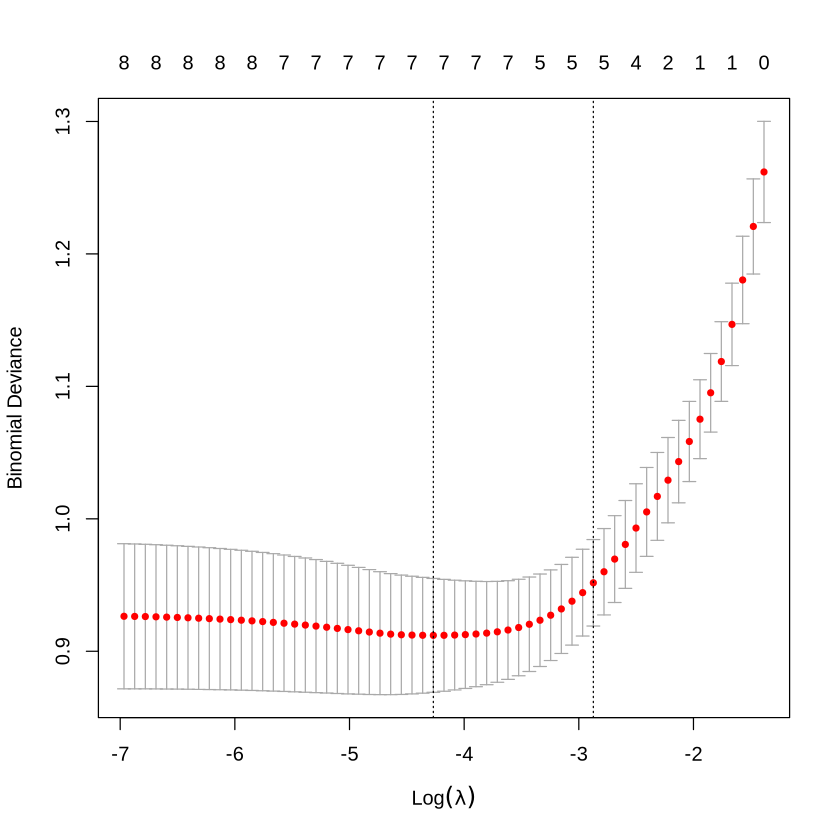

In [10]:
# Lasso regression model (with cross-validation)
x_train <- as.matrix(train_data %>% select(-Outcome))
y_train <- train_data$Outcome

lasso_model <- cv.glmnet(x_train, y_train, alpha = 1, family = "binomial")
plot(lasso_model)

# Coefficients at the best lambda
lasso_best_lambda <- lasso_model$lambda.min
cat("Best Lambda for Lasso:", lasso_best_lambda, "\n")
lasso_coefs <- coef(lasso_model, s = "lambda.min")
print(lasso_coefs)

# Predictions and evaluation
x_test <- as.matrix(test_data %>% select(-Outcome))
lasso_pred_prob <- predict(lasso_model, x_test, s = "lambda.min", type = "response")
lasso_pred <- ifelse(lasso_pred_prob > 0.5, 1, 0)
lasso_conf_matrix <- table(Predicted = lasso_pred, Actual = test_data$Outcome)
cat("Confusion Matrix (Lasso Regression):\n")
print(lasso_conf_matrix)

# Accuracy
lasso_accuracy <- sum(diag(lasso_conf_matrix)) / sum(lasso_conf_matrix)
cat("Accuracy (Lasso Regression):", lasso_accuracy, "\n")

# AUC Calculation for Lasso Regression
lasso_roc_pred <- prediction(lasso_pred_prob, test_data$Outcome)
lasso_roc_perf <- performance(lasso_roc_pred, measure = "tpr", x.measure = "fpr")
auc_lasso <- performance(lasso_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Lasso Regression):", auc_lasso, "\n")

### (3) Discussion

#### Summary of Findings

In this analysis, we set out to determine the diagnostic factors most strongly associated with diabetes in a dataset of Pima Indian women. We utilized **Logistic Regression** and **Lasso Regression** models to identify key predictors and assess their effectiveness in predicting the outcome variable, whether the individual has diabetes (binary classification: 0 = no, 1 = yes).

1. **Logistic Regression Results**:
   - **Significant predictors** of diabetes in the logistic regression model include:
     - **Glucose** (p-value < 0.001): Glucose levels are strongly correlated with the likelihood of diabetes. This aligns with known research that high glucose levels are a primary factor in the diagnosis of diabetes.
     - **Diabetes Pedigree Function** (p-value = 0.0232): This measure of family history is another significant predictor, suggesting that genetic predisposition plays a role in diabetes risk.
     - **BMI** (p-value = 0.0668): Though not highly significant (p-value slightly greater than 0.05), BMI also shows a trend suggesting that higher body mass index increases the likelihood of diabetes.
   - **Other variables** like **Pregnancies**, **Blood Pressure**, **Skin Thickness**, and **Insulin** did not show strong significance. For example, insulin had a p-value of 0.4744, indicating that its effect on predicting diabetes was negligible in this dataset, which could be a result of multicollinearity or a data issue (e.g., many zero values).
   - The **AUC** for the logistic regression model was **0.8535**, indicating a good predictive performance. The model's accuracy was 78.21%, meaning it correctly classified 78.21% of the observations, though there is room for improvement, particularly in reducing false positives (12 predicted non-diabetic as diabetic).

2. **Lasso Regression Results**:
   - The **Lasso Regression** model was applied to help identify the most important predictors while also regularizing the coefficients to prevent overfitting.
   - The **Best Lambda** found was **0.0139**, indicating the optimal level of regularization that minimizes model complexity while maintaining predictive performance.
   - Key predictors in the Lasso model are similar to those in the logistic regression model, including **Glucose**, **BMI**, and **Diabetes Pedigree Function**. However, **Blood Pressure** and **Insulin** were excluded from the model due to their coefficients being shrunk to zero, suggesting they are less relevant in predicting diabetes in this dataset.
   - The **AUC** for the Lasso model was **0.8513**, slightly lower than the logistic regression model (0.8535), with an accuracy of **76.92%**. Although the Lasso model has a slightly lower accuracy, it is more robust in handling multicollinearity and can generalize better to unseen data.

#### Implications and Impact

- **Glucose** levels remain the strongest predictor of diabetes in both models, which is consistent with existing medical research that links high blood glucose levels with the onset of diabetes. Therefore, focusing on glucose monitoring and management could be crucial for early detection and prevention.
- **Diabetes Pedigree Function** also plays an important role, indicating that family history is a significant risk factor. This suggests that individuals with a family history of diabetes should be more vigilant in screening and managing potential risk factors.
- The **slightly weaker performance of the Lasso model** highlights that while regularization is helpful for reducing model complexity and preventing overfitting, it may exclude some potentially useful predictors. This suggests a trade-off between interpretability and performance, as models with fewer predictors are easier to explain but might miss out on subtle relationships between variables.
  
#### Model Improvements

While both models showed good predictive performance, there are areas where they can be improved:

1. **Data Preprocessing**:
   - Although we addressed missing values and outliers, additional techniques like **feature scaling** or **normalization** could potentially improve model performance, especially for models like logistic regression that may be sensitive to the scale of the data.
   - Further exploration of **interaction terms** (e.g., interactions between BMI and glucose levels) could reveal more complex relationships in predicting diabetes.
   
2. **Model Tuning**:
   - For the **Lasso model**, fine-tuning the regularization parameter (lambda) using **cross-validation** could provide a more accurate regularization strength.
   - The **Logistic Regression** model can also benefit from more rigorous **hyperparameter tuning** (e.g., adjusting for different interaction terms or polynomial terms).
   
3. **Alternative Models**:
   - Other machine learning models like **Random Forests** or **Support Vector Machines** (SVM) could be explored to improve prediction accuracy. These models may perform better with non-linear relationships and interactions between variables.
   - Additionally, **ensemble methods** (e.g., boosting or bagging) could combine the strengths of multiple models to improve predictive power.

#### Future Research Directions

This study could lead to several interesting follow-up questions and avenues for further research:

1. **Impact of More Variables**:
   - Investigating the inclusion of other health-related features, such as diet, physical activity, or genetic markers, could enhance the model's predictive accuracy.
   
2. **Data Imbalance**:
   - Given that the dataset has a relatively balanced number of diabetic and non-diabetic individuals, future studies could focus on handling imbalanced datasets, especially if we expand to other populations where one class (diabetic or non-diabetic) might be overrepresented.
   
3. **Longitudinal Studies**:
   - Long-term data or longitudinal studies could track the development of diabetes over time. This could help understand how risk factors change and interact over the years and refine early warning systems for diabetes.

4. **Broader Applications**:
   - This model could be adapted for use in clinical settings, assisting healthcare providers in identifying patients at risk of developing diabetes, thus allowing for early intervention strategies and personalized healthcare plans.

In conclusion, both the **Logistic Regression** and **Lasso Regression** models demonstrate that key variables such as **Glucose**, **BMI**, and **Diabetes Pedigree Function** are critical predictors of diabetes in this dataset. While logistic regression shows slightly better performance, the Lasso model offers a more robust framework for handling potential overfitting. Improvements can be made by exploring alternative models, refining the preprocessing steps, and investigating more complex relationships within the data.